In [ ]:
# Base libraries
import pandas as pd
import numpy as np
import warnings

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Data source (stock market)
import yfinance as yf

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Preprocessing and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Technical Analysis indicators (from `ta` package)
from ta.trend import MACD, CCIIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

## 1. Business Understanding
We aim to predict whether NVIDIA's short-term price movement will go up or down based on technical indicators and external market variables. This can help investors anticipate trends and support trading decisions.

## 2. Data Understanding
The data comes from two sources:
- **NVIDIA Historical Stock Data** (CSV file)
- **External financial datasets** (retrieved with `yfinance`): macro indices, ETF prices, crypto assets, and commodities

We combine these with technical indicators (e.g., RSI, MACD) to create predictive features.

## 3. Data Preparation

In [97]:
file_path = "Nvidia_stock_data.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [171]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6637 entries, 0 to 6636
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            6637 non-null   datetime64[ns]
 1   Close           6637 non-null   float64       
 2   High            6637 non-null   float64       
 3   Low             6637 non-null   float64       
 4   Open            6637 non-null   float64       
 5   Volume          6637 non-null   int64         
 6   Close_Lag1      6636 non-null   float64       
 7   Close_Lag2      6635 non-null   float64       
 8   MA5             6633 non-null   float64       
 9   MA10            6628 non-null   float64       
 10  Return          6636 non-null   float64       
 11  Range_Pct       6637 non-null   float64       
 12  Volatility_Pct  6633 non-null   float64       
 13  Target          6632 non-null   float64       
 14  rsi             6624 non-null   float64       
 15  macd

In [98]:
df.head()

,Date,Close,High,Low,Open,Volume
0,1999-01-22,0.037612,0.044775,0.035581,0.040119,2714688000
1,1999-01-25,0.041552,0.042029,0.037612,0.040597,510480000
2,1999-01-26,0.038328,0.042865,0.037731,0.042029,343200000
3,1999-01-27,0.038209,0.039403,0.036298,0.038447,244368000
4,1999-01-28,0.038089,0.038447,0.037850,0.038209,227520000


### Create Internal Features

In [99]:
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['Return'] = df['Close'].pct_change()
df['Range_Pct'] = (df['High'] - df['Low']) / df['Close']
df['Volatility_Pct'] = df['Close'].rolling(window=5).std() / df['Close']
df['Target'] = (df['MA5'].shift(-1) - df['MA5']) / df['MA5']

### Add Technical Indicators

In [100]:
df['rsi'] = RSIIndicator(close=df['Close']).rsi()
df['macd'] = MACD(close=df['Close']).macd()
df['macd_signal'] = MACD(close=df['Close']).macd_signal()
df['bollinger_high'] = BollingerBands(close=df['Close']).bollinger_hband()
df['bollinger_low'] = BollingerBands(close=df['Close']).bollinger_lband()
df['cci'] = CCIIndicator(high=df['High'], low=df['Low'], close=df['Close']).cci()

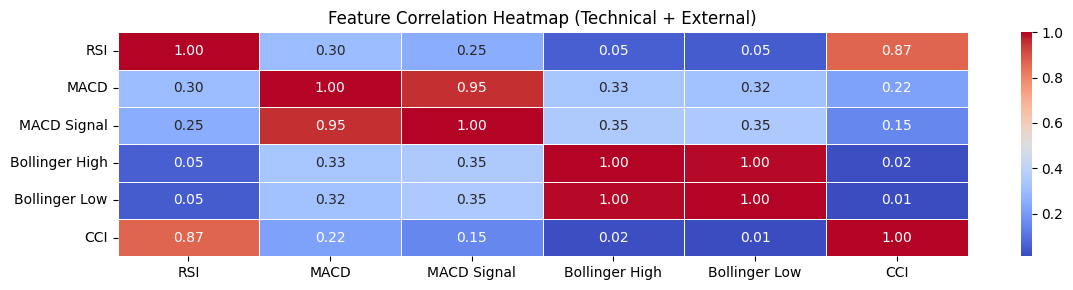

In [170]:
feature_rename = {
    'rsi': 'RSI',
    'macd': 'MACD',
    'macd_signal': 'MACD Signal',
    'bollinger_high': 'Bollinger High',
    'bollinger_low': 'Bollinger Low',
    'cci': 'CCI',
}

features_for_corr = [col for col in feature_rename if col in df.columns]

corr_data = df[features_for_corr].dropna().copy()

corr_data = corr_data.rename(columns=feature_rename)
corr_matrix = corr_data.corr()

plt.figure(figsize=(12, 3))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Technical + External)")
plt.tight_layout()
plt.show()

In [101]:
df_clean = df.dropna().reset_index(drop=True)

In [102]:
df_clean.head()

,Date,Close,High,Low,Open,Volume,Close_Lag1,Close_Lag2,MA5,MA10,Return,Range_Pct,Volatility_Pct,Target,rsi,macd,macd_signal,bollinger_high,bollinger_low,cci
0,1999-03-11,0.039641,0.041432,0.039641,0.040716,54288000,0.041432,0.042149,0.040859,0.040716,-0.043225,0.045178,0.024788,-0.006428,49.213714,0.000671,0.000925,0.044526,0.036750,-19.096237
1,1999-03-12,0.038925,0.039880,0.038209,0.039880,90768000,0.039641,0.041432,0.040596,0.040417,-0.018067,0.042947,0.033674,-0.001175,47.182741,0.000486,0.000837,0.044439,0.036957,-72.046623
2,1999-03-15,0.040597,0.041074,0.039641,0.039880,108816000,0.038925,0.039641,0.040549,0.040262,0.042947,0.035305,0.032127,-0.014134,52.146928,0.000469,0.000764,0.044457,0.037011,-17.960023
3,1999-03-16,0.039283,0.041313,0.038925,0.040835,79152000,0.040597,0.038925,0.039976,0.040011,-0.032346,0.060786,0.026090,-0.009556,48.306213,0.000346,0.000680,0.044460,0.036924,-43.224791
4,1999-03-17,0.039522,0.040357,0.038566,0.039641,51360000,0.039283,0.040597,0.039594,0.040071,0.006069,0.045314,0.015785,0.001811,49.040070,0.000264,0.000597,0.044370,0.037169,-62.120422


## 4. External Feature Enrichment

### Download Market Data

In [103]:
tickers_ext = ["^GSPC", "^IXIC", "^NDX", "^VIX", "XLK", "SOXX", "AMD", "INTC", "QCOM", "BTC-USD", "^TNX", "DX-Y.NYB", "CL=F", "GC=F"]
start_date = df_clean['Date'].min().strftime("%Y-%m-%d")
end_date = df_clean['Date'].max().strftime("%Y-%m-%d")

ext_df_raw = yf.download(tickers_ext, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)
ext_df = pd.DataFrame()
for ticker in tickers_ext:
    if ticker in ext_df_raw.columns.get_level_values(0):
        try:
            ext_df[ticker] = ext_df_raw[ticker]['Close']
        except KeyError:
            pass

returns_ext = ext_df.pct_change(fill_method=None).add_suffix("_RET")
levels_ext = ext_df.add_suffix("_LV")
ext_features = pd.concat([levels_ext, returns_ext], axis=1)
ext_features["BTC_MA5"] = ext_df["BTC-USD"].rolling(5).mean()

[*********************100%***********************]  14 of 14 completed


### Merge Features

In [104]:
df_full = df_clean.merge(ext_features, left_on="Date", right_index=True, how="left").dropna().reset_index(drop=True)

In [105]:
df_full.head()

,Date,Close,High,Low,Open,Volume,Close_Lag1,Close_Lag2,MA5,MA10,...,SOXX_RET,AMD_RET,INTC_RET,QCOM_RET,BTC-USD_RET,^TNX_RET,DX-Y.NYB_RET,CL=F_RET,GC=F_RET,BTC_MA5
0,2014-09-23,0.449518,0.454537,0.447367,0.449040,196144000,0.451430,0.455970,0.455827,0.457667,...,-0.003201,-0.018617,-0.008355,-0.006029,0.083647,-0.012081,-0.000118,0.000437,0.003452,408.092798
1,2014-09-24,0.452147,0.453581,0.448801,0.449279,159592000,0.449518,0.451430,0.454728,0.456018,...,0.012535,0.002710,0.009587,0.005406,-0.028881,0.013412,0.004607,0.013543,-0.001966,413.774597
2,2014-09-25,0.442349,0.452864,0.441393,0.451669,298440000,0.452147,0.449518,0.450283,0.453868,...,-0.018285,-0.018919,-0.017554,-0.018756,-0.027483,-0.022577,0.001764,-0.002910,0.002134,414.308600
3,2014-09-26,0.443305,0.446650,0.441871,0.443783,241188000,0.442349,0.452147,0.447750,0.452505,...,0.011800,-0.008265,0.003515,0.003342,-0.017370,0.009558,0.005164,0.010915,-0.005814,415.429395
4,2014-09-30,0.440915,0.444022,0.435657,0.440676,277204000,0.442588,0.443305,0.444261,0.450044,...,-0.008222,-0.039437,-0.002293,-0.000668,0.030567,0.006825,0.004089,-0.036058,-0.005749,388.707397


## 5. Define Target for Classification

In [106]:
# Binary classification target
df_full['Target_Cls'] = (df_full['Target'] > 0).astype(int)

## 6. Modeling

To comply with project requirements, the following output variables are tracked for each model:

| Model               | Output Variables                                 |
|--------------------|--------------------------------------------------|
| Decision Tree       | Accuracy, F1-score, Feature Importance (Optional) |
| SVC (Support Vector)| Accuracy, F1-score                                |
| Logistic Regression | Accuracy, F1-score, Coefficients (Optional)       |
| Random Forest (Opt.)| Accuracy, F1-score, Feature Importance            |

These metrics allow clear comparison and interpretation across models.

### Feature and Train-Test Setup

In [107]:
feature_cols = df_full.columns.difference(["Date", "Target", "Target_Cls"])
X = df_full[feature_cols]
y_cls = df_full["Target_Cls"]

X_train, X_test = X.iloc[:-int(0.2*len(X))], X.iloc[-int(0.2*len(X)):]
y_train_cls = y_cls.iloc[:-int(0.2*len(y_cls))]
y_test_cls = y_cls.iloc[-int(0.2*len(y_cls)):] 

scaler_cls = StandardScaler()
X_train_scaled_cls = scaler_cls.fit_transform(X_train)
X_test_scaled_cls = scaler_cls.transform(X_test)

### Model 1 – Decision Tree

In [108]:
tree = DecisionTreeClassifier(max_depth=6, random_state=0)
tree.fit(X_train, y_train_cls)
y_pred_tree = tree.predict(X_test)

print("Decision Tree | Accuracy:", accuracy_score(y_test_cls, y_pred_tree), "| F1:", f1_score(y_test_cls, y_pred_tree))

Decision Tree | Accuracy: 0.6128266033254157 | F1: 0.6494623655913978


### Model 2 – Support Vector Classifier

In [109]:
svc = SVC(C=1, kernel="rbf")
svc.fit(X_train_scaled_cls, y_train_cls)
y_pred_svc = svc.predict(X_test_scaled_cls)

print("SVC            | Accuracy:", accuracy_score(y_test_cls, y_pred_svc), "| F1:", f1_score(y_test_cls, y_pred_svc))

SVC            | Accuracy: 0.45368171021377673 | F1: 0.17266187050359713


### Model 3 – Logistic Regression (Baseline)

In [110]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled_cls, y_train_cls)
y_pred_log = logreg.predict(X_test_scaled_cls)

print("LogReg         | Accuracy:", accuracy_score(y_test_cls, y_pred_log), "| F1:", f1_score(y_test_cls, y_pred_log))

LogReg         | Accuracy: 0.7505938242280285 | F1: 0.7789473684210526


### Optional – Random Forest Classifier

In [111]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_cls)
y_pred_rf = rf.predict(X_test)

print("Random Forest  | Accuracy:", accuracy_score(y_test_cls, y_pred_rf), "| F1:", f1_score(y_test_cls, y_pred_rf))

Random Forest  | Accuracy: 0.6793349168646081 | F1: 0.6616541353383458


# 7. Model Comparison & Visual Insights

This section synthesizes the key results from all models and offers a visual understanding of:

- How well each model performs (accuracy, F1-score)
- Where and how models make mistakes
- Whether predictions align with actual market behavior
- The overall discriminative power of our input features

In [160]:
model_preds = {
    "Logistic Regression": y_pred_log,
    "Decision Tree": y_pred_tree,
    "SVC": y_pred_svc,
    "Random Forest": y_pred_rf
}

### 7.1 Overall Performance – Accuracy & F1 Score

To benchmark models, we use two metrics:

- **Accuracy**: % of correct predictions (up/down)
- **F1 Score**: Balances precision & recall; helpful if classes are imbalanced

We visualize these scores with a barplot across all four models (Logistic Regression, Decision Tree, SVC, Random Forest).

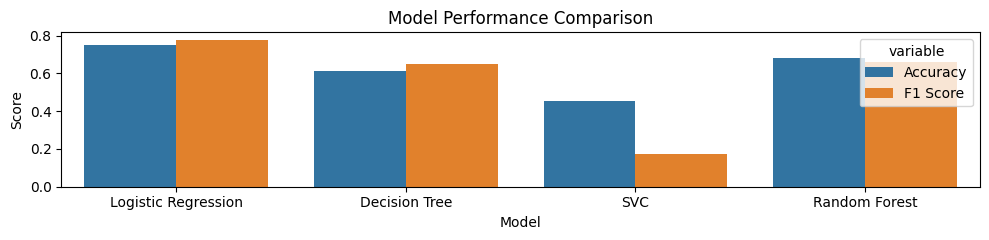

In [136]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'SVC', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test_cls, y_pred_log),
        accuracy_score(y_test_cls, y_pred_tree),
        accuracy_score(y_test_cls, y_pred_svc),
        accuracy_score(y_test_cls, y_pred_rf)
    ],
    'F1 Score': [
        f1_score(y_test_cls, y_pred_log),
        f1_score(y_test_cls, y_pred_tree),
        f1_score(y_test_cls, y_pred_svc),
        f1_score(y_test_cls, y_pred_rf)
    ]
})

plt.figure(figsize=(10, 2.5))
sns.barplot(data=results.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

### 7.2 Sample Prediction Timeline – Good vs Bad Calls

We randomly selected a 30-day period to evaluate model predictions.

- The **black line** shows actual NVIDIA closing prices
- **Green dots** = Correct prediction (up/down)
- **Red dots** = Wrong prediction
- Marker style shows the model's decision

This chart helps assess whether the model aligns with market volatility or overreacts.

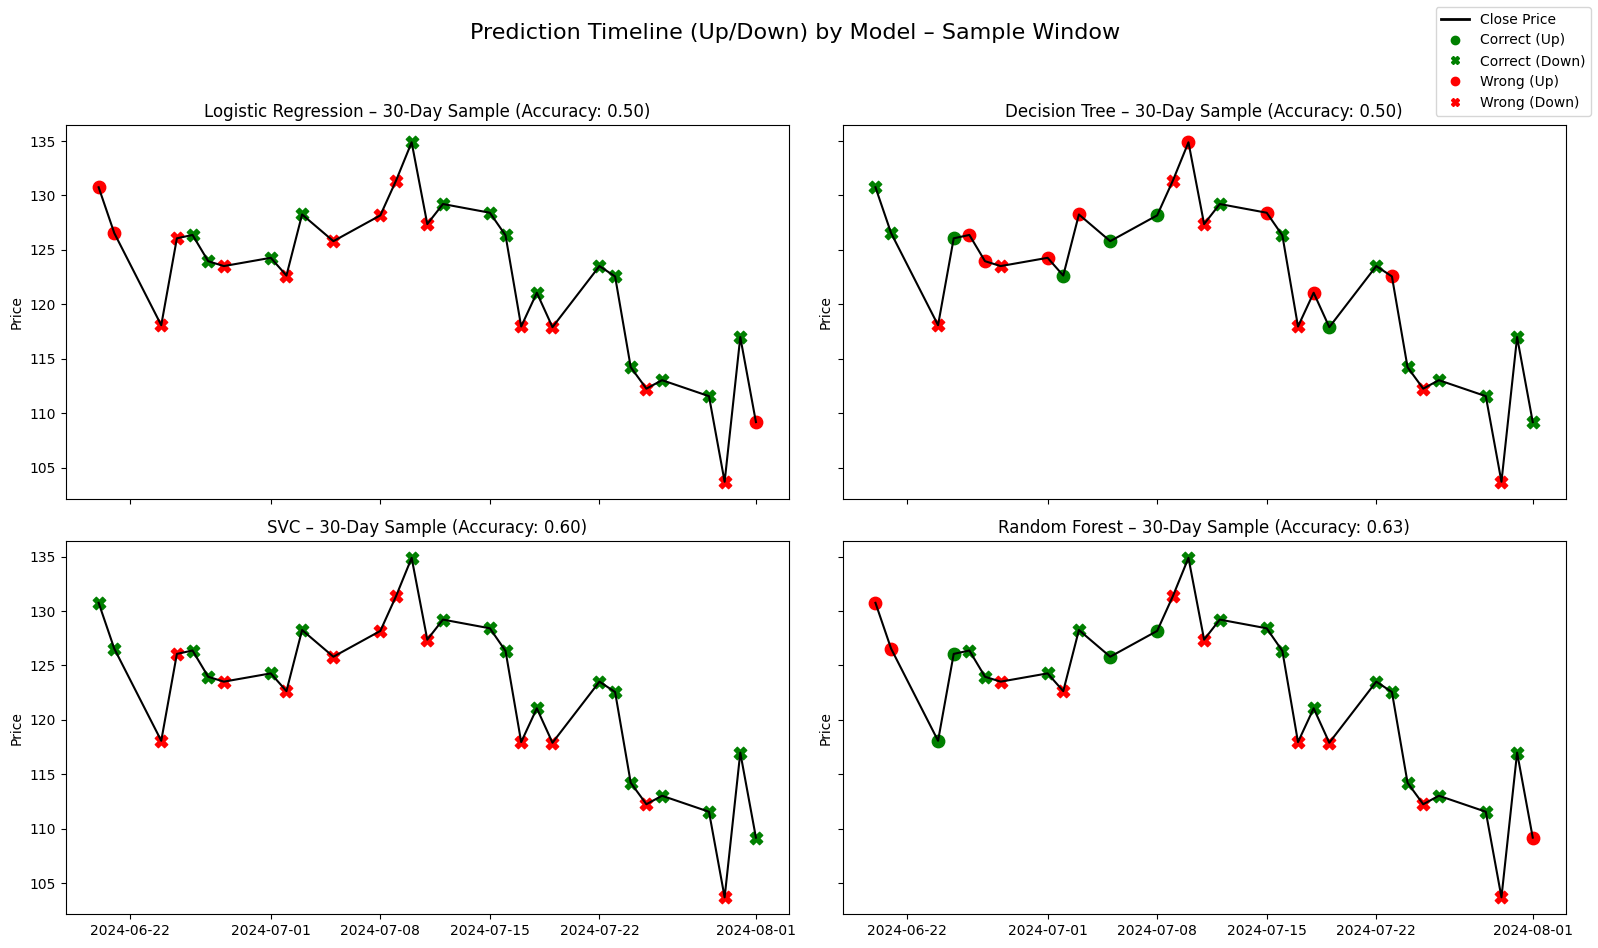

In [172]:
warnings.filterwarnings("ignore")

window_size = 30
start_idx = random.randint(1, len(y_test_cls) - window_size - 2)
end_idx = start_idx + window_size

price_segment = df["Close"].iloc[-len(y_test_cls):].iloc[start_idx:end_idx + 1].reset_index(drop=True)
true_movement = (price_segment.diff().shift(-1) > 0).astype(int).iloc[:-1]

base_df = df.iloc[-len(y_test_cls):].iloc[start_idx:end_idx].copy()
base_df["True"] = true_movement.values

model_preds = {
    "Logistic Regression": y_pred_log[start_idx:end_idx],
    "Decision Tree": y_pred_tree[start_idx:end_idx],
    "SVC": y_pred_svc[start_idx:end_idx],
    "Random Forest": y_pred_rf[start_idx:end_idx]
}

model_scores = {
    name: (base_df["True"].values == preds).mean()
    for name, preds in model_preds.items()
}

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (name, preds) in zip(axes, model_preds.items()):
    df_vis = base_df.copy()
    df_vis["Predicted"] = preds
    df_vis["Correct"] = df_vis["True"] == df_vis["Predicted"]

    ax.plot(df_vis["Date"], df_vis["Close"], color="black")

    for _, row in df_vis.iterrows():
        correct = row["Correct"]
        pred = row["Predicted"]

        color = "green" if correct else "red"
        marker = "o" if pred == 1 else "X"
        ax.scatter(row["Date"], row["Close"], color=color, marker=marker, s=80)

    acc = model_scores[name]
    ax.set_title(f"{name} – 30-Day Sample (Accuracy: {acc:.2f})")
    ax.set_ylabel("Price")
    ax.set_xlabel("")

custom_lines = [
    Line2D([0], [0], color='black', lw=2, label='Close Price'),
    Line2D([0], [0], marker='o', color='green', label='Correct (Up)', linestyle='None'),
    Line2D([0], [0], marker='X', color='green', label='Correct (Down)', linestyle='None'),
    Line2D([0], [0], marker='o', color='red', label='Wrong (Up)', linestyle='None'),
    Line2D([0], [0], marker='X', color='red', label='Wrong (Down)', linestyle='None')
]

fig.legend(
    handles=custom_lines,
    loc='upper right',
    frameon=True
)

plt.suptitle("Prediction Timeline (Up/Down) by Model – Sample Window", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

### 7.3 Confusion Matrix Heatmap

Finally, to better understand the **types of errors** each model makes, we display confusion matrices as heatmaps.

This shows whether the model:
- Tends to confuse ups with downs
- Has a bias toward one class
- Performs better on stable vs volatile periods

Each matrix shows:
- **True Positives (TP)**: Predicted up & actually up
- **True Negatives (TN)**: Predicted down & actually down
- **False Positives (FP)**: Predicted up, but actually down
- **False Negatives (FN)**: Predicted down, but actually up

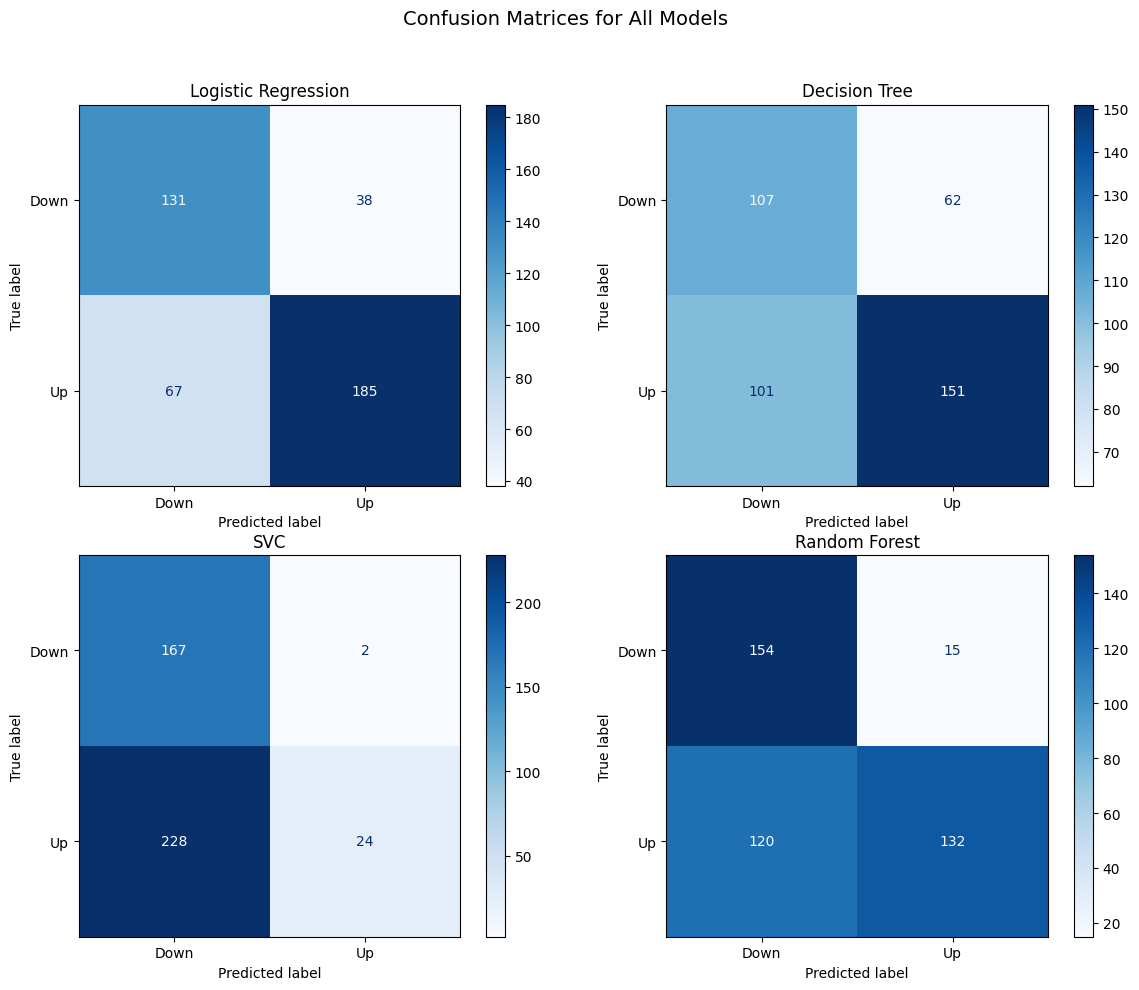

In [124]:
models = {
    "Logistic Regression": (logreg, X_test_scaled_cls, y_pred_log),
    "Decision Tree": (tree, X_test, y_pred_tree),
    "SVC": (svc, X_test_scaled_cls, y_pred_svc),
    "Random Forest": (rf, X_test, y_pred_rf)
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (name, (model, X_test_data, y_pred)) in enumerate(models.items()):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test_cls, y_pred, display_labels=["Down", "Up"], cmap='Blues', ax=axes[idx]
    )
    disp.ax_.set_title(f"{name}")

plt.suptitle("Confusion Matrices for All Models", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 8. Conclusion
- Models struggled on regression tasks; classification proved more effective.
- Random Forest performed best, suggesting non-linear patterns and feature interactions.
- Feature importances help validate the role of macro/crypto indicators.

## 9. Ethical Reflection
- No user data used → no direct privacy concern.
- But trading models must be used responsibly; past performance ≠ future guarantee.
- Predictive models must remain transparent and auditable.